In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from datetime import datetime, timedelta
from control.modules.high_temperature import (
    HighTemperatureControl,
    HighTemperatureParameters,
    HighTemperatureAlarms,
)
from input_output.base import Stamped
from input_output.definitions.control import Valve
from input_output.definitions.simulation import (
    Boundary,
    HeatSource,
    Pcs,
    Thruster,
    ValvePosition,
)
from input_output.modules.high_temperature import (
   HighTemperatureControlValues,
   HighTemperatureSensorValues,
   HighTemperatureSimulationInputs,
   HighTemperatureSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
from simulation.models.fmu_paths import high_temperature_path

start_time = datetime.fromtimestamp(0)
duration = timedelta(minutes=3 - 1)


simulation_inputs = HighTemperatureSimulationInputs(
         thrusters_aft=Thruster(
            heat_flow=Stamped.stamp(9000), active=Stamped.stamp(True)
        ),
        thrusters_fwd=Thruster(
            heat_flow=Stamped.stamp(4300), active=Stamped.stamp(True)
        ),
        thrusters_seawater_supply=Boundary(
            temperature=Stamped.stamp(32), flow=Stamped.stamp(64)
        ),
        thrusters_pcs=Pcs(mode=Stamped.stamp("propulsion")),
        pvt_main_fwd=HeatSource(heat_flow=Stamped.stamp(16000)),
        pvt_main_aft=HeatSource(heat_flow=Stamped.stamp(16000)),
        pvt_owners=HeatSource(heat_flow=Stamped.stamp(8000)),
        pvt_pump_failure_switch_main_fwd=ValvePosition(
            position_rel=Stamped.stamp(Valve.CLOSED)
        ),
        pvt_pump_failure_switch_main_aft=ValvePosition(
            position_rel=Stamped.stamp(Valve.CLOSED)
        ),
        pvt_pump_failure_switch_owners=ValvePosition(
            position_rel=Stamped.stamp(Valve.CLOSED)
        ),
        pvt_seawater_supply=Boundary(
            temperature=Stamped.stamp(32), flow=Stamped.stamp(64)
        ),
        pcm_freshwater_supply=Boundary(
            temperature=Stamped.stamp(40), flow=Stamped.stamp(0)
        ),
        consumers_fahrenheit_supply=Boundary(
            temperature=Stamped.stamp(60), flow=Stamped.stamp(42)
        ),
        consumers_boosting_supply=Boundary(
            temperature=Stamped.stamp(40), flow=Stamped.stamp(29)
        ),
    )

control = HighTemperatureControl(HighTemperatureParameters())
control._thrusters_control.to_recovery()

high_temperature_model = SimulatorModel(
    fmu_path=high_temperature_path,
    sensor_values_cls=HighTemperatureSensorValues,
    control_values_cls=HighTemperatureControlValues,
    simulation_outputs_cls=HighTemperatureSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=HighTemperatureAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)

simulation = Simulator(high_temperature_model)

result = await simulation.run(5)

[WARNING] Warning: The following was detected at time: 0
[WARNING]   HTSystem_FMU.central_consumers.central_Consumers.consumer_fahrenheit_supply_split: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -0.25)
  Failed condition: central_consumers.central_Consumers.consumer_fahrenheit_supply_split.splitRatio_ >= -0.001

[WARNING] Warning: The following was detected at time: 0
[WARNING]   HTSystem_FMU.central_consumers.central_Consumers.consumer_fahrenheit_return_join: Flow splitRatio is far above 1. But it must be between 0 and 1. (is 1.25)
  Failed condition: central_consumers.central_Consumers.consumer_fahrenheit_return_join.splitRatio <= 1.001

[WARNING] Warning: The following was detected at time: 2.637550795947699E-29
[WARNING]   HTSystem_FMU.thruster_module.thrusterModule.flowJoin2: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -1.49057)
  Failed condition: thruster_module.thrusterModule.flowJoin2.splitRatio >= -0.0

/Users/alje/Repos/zero-thrs-control/analysis/analysis_utils.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  for end, mode in last_modes.items():


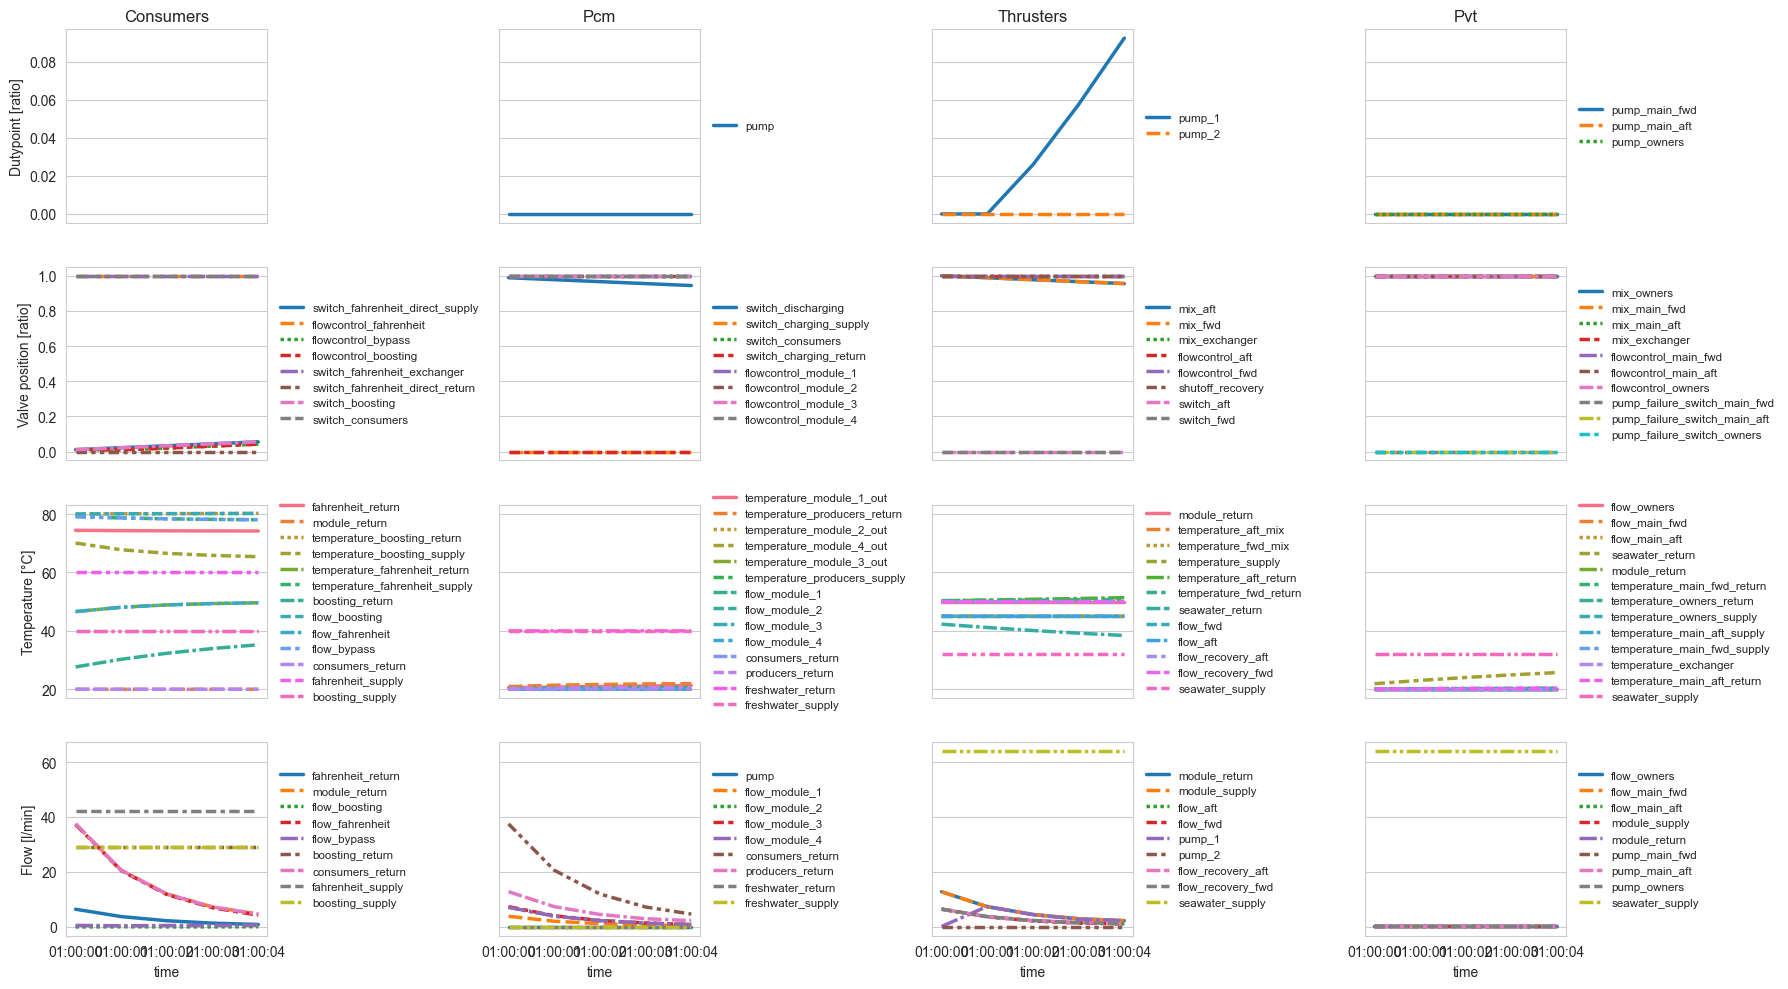

In [35]:
from analysis.analysis_utils import plot_result

plot_result(result, 'plots/high_temperature.png');